In [36]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import cv2
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

## Gathering data from 20 classes of stanford40 dataset
The chosen clases were:
['applauding', 'brushing_teeth', 'cleaning_floor', 'cutting_vegetables',
 'drinking', 'jumping', 'phoning', 'playing_guitar', 'pouring_liquid',
 'reading', 'running', 'taking_photos', 'texting', 'using_computer',
 'waving', 'writing_on_a_board', 'washing_dishes', 'smoking',
 'holding_a_umbrella', 'playing_violin']

## functions definitios

In [37]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [38]:
# if paticular landmark there add x,y,z to list else add zeros
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [39]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [40]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [42]:
def get_keypoins_images(class_list):
    for class_images in class_list:
        IMAGE_FILES = os.listdir(f'C://Users/igorb/Documents/action_images/{class_images}')
        IMAGE_FILES_PATH = ['C://Users/igorb/Documents/action_images/' + class_images + '/' + string for string in IMAGE_FILES]
        BG_COLOR = (192, 192, 192) # gray
        with mp_holistic.Holistic(
            static_image_mode=True,
            model_complexity=2,
            enable_segmentation=True,
            refine_face_landmarks=True) as holistic:
            i = 0
            for idx, file in enumerate(IMAGE_FILES):
                image = cv2.imread(f"C://Users/igorb/Documents/action_images/{class_images}/{file}")
                if type(image) == type(None):
                    continue
                image_height, image_width, _ = image.shape
                # Convert the BGR image to RGB before processing.
                results = holistic.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

                annotated_image = image.copy()
                #Image.fromarray(annotated_image).show()
                # Draw segmentation on the image.
                # To improve segmentation around boundaries, consider applying a joint
                # bilateral filter to "results.segmentation_mask" with "image".
                if results == None:
                    continue
                if type(results.segmentation_mask) == type(None):
                    continue
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                #npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(f'C://Users/igorb/Documents/action_images/holistic/{class_images}_holistic/{i}.npy', keypoints)
                i = i+1
                # Plot pose world landmarks.
                '''mp_drawing.plot_landmarks(
                    results.pose_world_landmarks, mp_holistic.POSE_CONNECTIONS)
                pil_image=Image.fromarray(annotated_image)'''
                #pil_image = pil_image.save(f"C://Users/igorb/Documents/action_images/holistic/{class_images}_holistic/{file}")                 
                #pil_image = pil_image.save(f"C://Users/igorb/Documents/action_images/{class_image}/{.jpg") 

In [43]:
def get_keypoins_videos(class_list_videos):
    #cap = cv2.VideoCapture(0)
    # Set mediapipe model 
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

        # NEW LOOP
        # Loop through actions
        #for action in actions:
        for action in class_list_videos:
            # Loop through sequences aka videos
            sequence = 0
            for image in tqdm(os.listdir(f'C://Users/igorb/Documents/UCF50/{action}')):
                print(image)
                video = cv2.VideoCapture(f'C://Users/igorb/Documents/UCF50/{action}/{image}')
                # Loop through video length aka sequence length
                if not (os.path.exists(f'C://Users/igorb/Documents/UCF50_holistic/{action}_holistic/{sequence}/')):
                    os.mkdir(f'C://Users/igorb/Documents/UCF50_holistic/{action}_holistic/{sequence}/')
                frame_num = 0
                grabbed, frame = video.read()
                print(grabbed)

                while grabbed:
                    # Make detections
                    image, results = mediapipe_detection(frame, holistic)
        
                    # Draw landmarks
                    draw_styled_landmarks(image, results)

                    #Export keypoints
                    keypoints = extract_keypoints(results)
                    print(keypoints)
                    input()
                    #npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                    #np.save(npy_path, keypoints)
                    np.save(f'C://Users/igorb/Documents/UCF50_holistic/{action}_holistic/{sequence}/{frame_num}', keypoints)
                    grabbed, frame = video.read()

                    frame_num = frame_num + 1

                sequence = sequence + 1
                print('foi 1')

        video.release()
        cv2.destroyAllWindows()

## Creating video sequences

In [44]:
class_list_videos = os.listdir(f'C://Users/igorb/Documents/UCF50/')

In [49]:
get_keypoins_videos(class_list_videos)

  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

v_BaseballPitch_g01_c01.avi
True
[0.25994378 0.20099616 0.044755   ... 0.         0.         0.        ]


  0%|                                                                                          | 0/150 [00:04<?, ?it/s]


KeyboardInterrupt: Interrupted by user

In [15]:
actions = np.array(class_list_videos)

### Testing mp holistic

In [2]:
import cv2
import mediapipe as mp
import numpy as np
from PIL import Image
import os
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

In [25]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [26]:
im = Image.open(r"C://Users/igorb/Documents/action_images/applauding/applauding_001.jpg")  

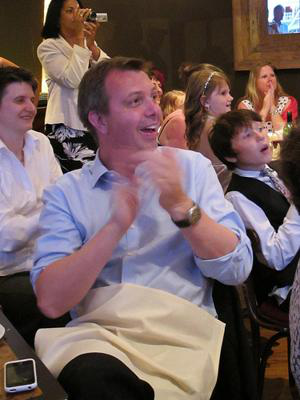

In [27]:
im

Nose coordinates: (151.52889490127563, 117.87891387939453)


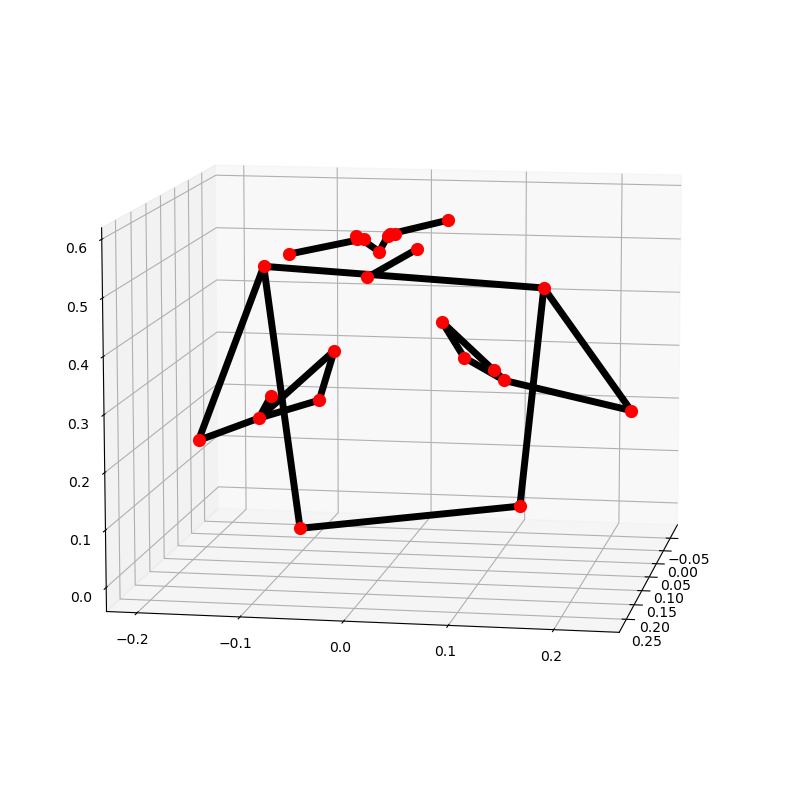

In [28]:
# For static images:
IMAGE_FILES = ["C://Users/igorb/Documents/action_images/applauding/applauding_001.jpg"]
BG_COLOR = (192, 192, 192) # gray
with mp_holistic.Holistic(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    refine_face_landmarks=True) as holistic:
    for idx, file in enumerate(IMAGE_FILES):
        image = cv2.imread(file)
        image_height, image_width, _ = image.shape
        # Convert the BGR image to RGB before processing.
        results = holistic.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if results.pose_landmarks:
            print(
                f'Nose coordinates: ('
                f'{results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].x * image_width}, '
                f'{results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].y * image_height})'
            )

        annotated_image = image.copy()
        # Draw segmentation on the image.
        # To improve segmentation around boundaries, consider applying a joint
        # bilateral filter to "results.segmentation_mask" with "image".
        condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
        bg_image = np.zeros(image.shape, dtype=np.uint8)
        bg_image[:] = BG_COLOR
        annotated_image = np.where(condition, annotated_image, bg_image)
        # Draw pose, left and right hands, and face landmarks on the image.
        mp_drawing.draw_landmarks(
            annotated_image,
            results.face_landmarks,
            mp_holistic.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.
            get_default_pose_landmarks_style())
        cv2.imwrite('/tmp/annotated_image' + str(idx) + '.png', annotated_image)
        # Plot pose world landmarks.
        mp_drawing.plot_landmarks(
            results.pose_world_landmarks, mp_holistic.POSE_CONNECTIONS)

In [29]:
PIL_image = Image.fromarray(np.uint8(annotated_image)).convert('RGB')

#PIL_image = Image.fromarray(numpy_image.astype('uint8'), 'RGB')

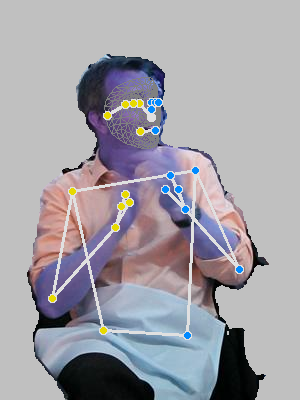

In [30]:
PIL_image

In [31]:
image2 = cv2.imread(r"applauding_001.jpg")

In [33]:
result_test = extract_keypoints(results)

In [34]:
np.save('test', result_test)

In [35]:
np.load('test.npy')

array([ 0.50509632,  0.29469728, -0.28640276, ...,  0.45281768,
        0.49421492, -0.02488342])

## Creating dataset with keypoints with .npy files

In [11]:
class_list_videos_holistic = [class_videos + '_holistic' for class_videos in class_list_videos]

In [14]:
for class_holistic in class_list_videos_holistic:
    os.mkdir(f'C://Users/igorb/Documents/UCF50_holistic/{class_holistic}')

In [11]:
class_list2 = ['applauding']

In [12]:
im_files = ['C://Users/igorb/Documents/action_images/' + string for string in class_list]

class_list = [
              'drinking', 'jumping', 'phoning', 'playing_guitar', 'pouring_liquid',
              'reading', 'running', 'taking_photos', 'texting', 'using_computer',
              'waving', 'writing_on_a_board', 'washing_dishes', 'smoking',
              'holding_a_umbrella', 'playing_violin']

In [68]:
get_keypoins_images(class_list)

## Testing webcam capture

In [16]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
cap.release()
cv2.destroyAllWindows()

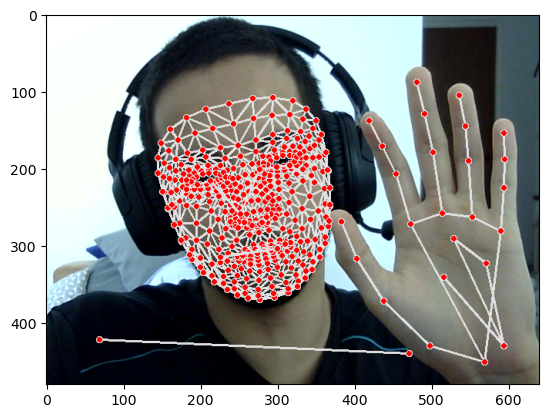

In [17]:
draw_landmarks(frame,results)
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)) 

## creating sequences

In [113]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [114]:
class_list_videos = os.listdir(f'C://Users/igorb/Documents/UCF50/')

In [115]:
actions = np.array(class_list_videos)

In [116]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'BaseballPitch': 0,
 'Basketball': 1,
 'BenchPress': 2,
 'Biking': 3,
 'Billiards': 4,
 'BreastStroke': 5,
 'CleanAndJerk': 6,
 'GolfSwing': 7,
 'JugglingBalls': 8,
 'JumpingJack': 9,
 'JumpRope': 10,
 'Lunges': 11,
 'PlayingGuitar': 12,
 'PlayingPiano': 13,
 'PullUps': 14,
 'Punch': 15,
 'PushUps': 16,
 'Rowing': 17,
 'SoccerJuggling': 18,
 'TennisSwing': 19}

In [117]:
sequence_length = 40

In [118]:
aux = 'applauding'

In [119]:
actions

array(['BaseballPitch', 'Basketball', 'BenchPress', 'Biking', 'Billiards',
       'BreastStroke', 'CleanAndJerk', 'GolfSwing', 'JugglingBalls',
       'JumpingJack', 'JumpRope', 'Lunges', 'PlayingGuitar',
       'PlayingPiano', 'PullUps', 'Punch', 'PushUps', 'Rowing',
       'SoccerJuggling', 'TennisSwing'], dtype='<U14')

In [120]:
sequences, labels = [], []
for action in actions:
    #for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
    for sequence in np.array(os.listdir(f'C://Users/igorb/Documents/UCF50_holistic/{action}_holistic/')).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(f'C://Users/igorb/Documents/UCF50_holistic/{action}_holistic/{sequence}/{frame_num}.npy')
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [127]:
len(labels)

2740

In [128]:
sequences[1][10].shape

(1662,)

In [90]:
y = to_categorical(labels).astype(int)

## train_test_split

In [130]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)   #one hot encoidng the labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [131]:
print(X_train.shape) 
print(X_test.shape) 
print(y_train.shape)
print(y_test.shape)

(2192, 40, 1662)
(548, 40, 1662)
(2192, 20)
(548, 20)


In [132]:
actions.shape

(20,)

## Biuld model

In [143]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [138]:
actions = np.array(class_list_videos)

In [139]:
actions

array(['BaseballPitch', 'Basketball', 'BenchPress', 'Biking', 'Billiards',
       'BreastStroke', 'CleanAndJerk', 'GolfSwing', 'JugglingBalls',
       'JumpingJack', 'JumpRope', 'Lunges', 'PlayingGuitar',
       'PlayingPiano', 'PullUps', 'Punch', 'PushUps', 'Rowing',
       'SoccerJuggling', 'TennisSwing'], dtype='<U14')

In [140]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=((40,1662))))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 40, 128)           916992    
                                                                 
 lstm_20 (LSTM)              (None, 40, 128)           131584    
                                                                 
 lstm_21 (LSTM)              (None, 64)                49408     
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 20)                660       
                                                                 
Total params: 1104884 (4.21 MB)
Trainable params: 1104

In [147]:
model_checkpoint_callback = ModelCheckpoint('lstm_video_classification.h5', monitor="categorical_accuracy",
                      save_best_only=True, save_weights_only=False)
model.fit(X_train, y_train, epochs=400, callbacks=[tb_callback, model_checkpoint_callback])

Epoch 1/400
69/69 [==============================] - 4s 51ms/step - loss: 2.9294 - categorical_accuracy: 0.0780
Epoch 2/400
 2/69 [..............................] - ETA: 3s - loss: 2.9631 - categorical_accuracy: 0.0156    

C:\Users\igorb\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 4s 52ms/step - loss: 2.9277 - categorical_accuracy: 0.0712
Epoch 3/400
69/69 [==============================] - 3s 50ms/step - loss: 2.9264 - categorical_accuracy: 0.0780
Epoch 4/400
69/69 [==============================] - 3s 51ms/step - loss: 2.9251 - categorical_accuracy: 0.0780
Epoch 5/400
69/69 [==============================] - 4s 52ms/step - loss: 2.9237 - categorical_accuracy: 0.0785
Epoch 6/400
69/69 [==============================] - 4s 51ms/step - loss: 2.9223 - categorical_accuracy: 0.0785
Epoch 7/400
69/69 [==============================] - 4s 52ms/step - loss: 2.9209 - categorical_accuracy: 0.0785
Epoch 8/400
69/69 [==============================] - 4s 53ms/step - loss: 2.9201 - categorical_accuracy: 0.0789
Epoch 9/400
69/69 [==============================] - 4s 52ms/step - loss: 2.9186 - categorical_accuracy: 0.0789
Epoch 10/400
69/69 [==============================] - 4s 53ms/step - loss: 2.9174 - categorical_accuracy: 0.0789
Epo

## Predictions

In [154]:
# predictions before training
res = model.predict(X_test)
for i in range(0,5):
    print('expected class')
    print(actions[np.argmax(y_test[i])])
    print('predicted class')
    print(actions[np.argmax(res[i])])



18/18 [==============================] - 0s 24ms/step
expected class
PushUps
predicted class
PlayingGuitar
expected class
Lunges
predicted class
JugglingBalls
expected class
JumpRope
predicted class
PlayingGuitar
expected class
Biking
predicted class
BenchPress
expected class
PushUps
predicted class
PlayingGuitar


## Save Weights

In [152]:
#model.save('lstm_video_classification.h5')
#del model

In [153]:
model.load_weights('lstm_video_classification.h5')

## Evaluation using Confusion Matrix and Accuracy

In [156]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd

yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

print(multilabel_confusion_matrix(ytrue, yhat))
print(accuracy_score(ytrue, yhat))

18/18 [==============================] - 0s 22ms/step
[[[508   0]
  [ 40   0]]

 [[515   0]
  [ 33   0]]

 [[253 264]
  [  7  24]]

 [[511   3]
  [ 34   0]]

 [[524   0]
  [ 24   0]]

 [[526   2]
  [ 20   0]]

 [[521   0]
  [ 27   0]]

 [[524   0]
  [ 24   0]]

 [[478  52]
  [  4  14]]

 [[522   0]
  [ 26   0]]

 [[523   0]
  [ 25   0]]

 [[515   0]
  [ 33   0]]

 [[420  96]
  [ 30   2]]

 [[525   0]
  [ 23   0]]

 [[523   0]
  [ 25   0]]

 [[516   1]
  [ 31   0]]

 [[530   0]
  [ 18   0]]

 [[485  37]
  [ 11  15]]

 [[488  37]
  [ 22   1]]

 [[513   0]
  [ 35   0]]]
0.10218978102189781


## As it's possible to see, the model has a mediocre performance. In training we could see that the loss and accuracy were not converging at any point. Considering we have 20 classes, a accuracy of 10.2% at least is better than 5%, which would be here the model was considered to not have learned at all. Probably for some  classes, it was hard to draw body landmarks, as the video quality is not very good and many of the actions are performed far from the camera. Probably with a better dataset and more time for training and upgrading the model it would be possible to achieve better results.